Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras
from keras.preprocessing import text,sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout

import warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Load and Check Data

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
real_data = pd.read_csv('/content/drive/MyDrive/archive (2)/True.csv')
fake_data = pd.read_csv('/content/drive/MyDrive/archive (2)/Fake.csv')

In [ ]:
real_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
#add column
real_data['target'] = 1
fake_data['target'] = 0

In [ ]:
real_data.tail()

,title,text,subject,date,target
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1
21416,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",1


In [ ]:
#Merging the 2 datasets
data = pd.concat([real_data, fake_data], ignore_index=True, sort=False)
data.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [ ]:
data.isnull().sum()

title      0
text       0
subject    0
date       0
target     0
dtype: int64

#Visualization
1.Count of Fake and Real Data

0    23481
1    21417
Name: target, dtype: int64


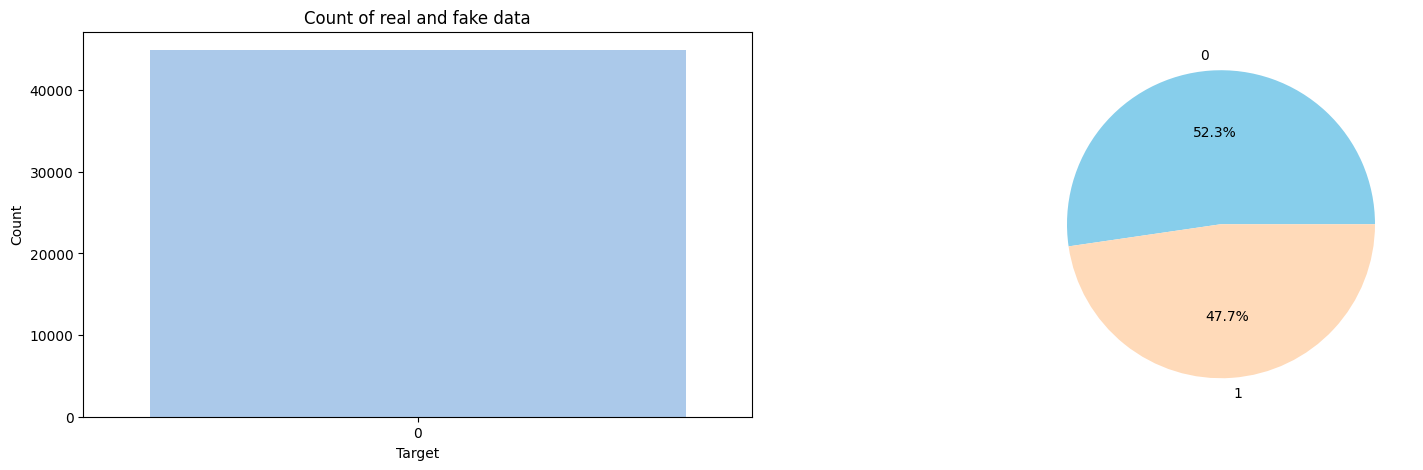

In [ ]:
print(data["target"].value_counts())
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.countplot(data.target,ax=ax[0],palette="pastel");
g1.set_title("Count of real and fake data")
g1.set_ylabel("Count")
g1.set_xlabel("Target")
g2 = plt.pie(data["target"].value_counts().values,explode=[0,0],labels=data.target.value_counts().index, autopct='%1.1f%%',colors=['SkyBlue','PeachPuff'])
fig.show()



2.Distribution of The Subject According to Real and Fake Data

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64


Text(0.5, 1.0, 'Distribution of The Subject According to Real and Fake Data')

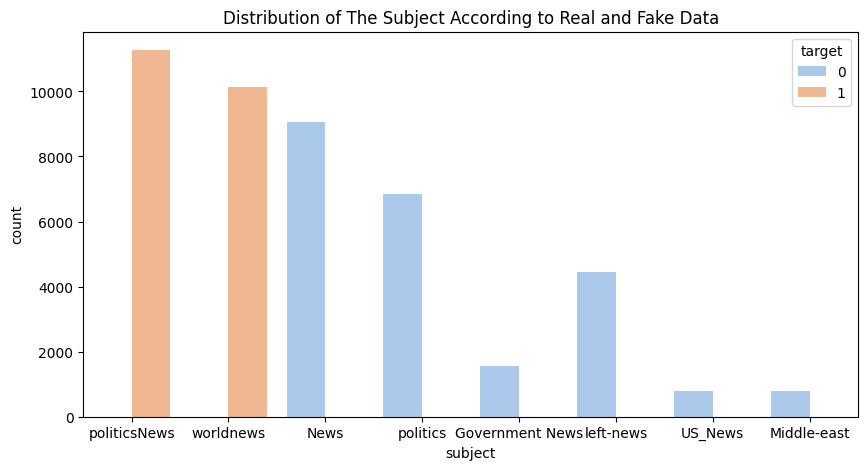

In [ ]:

print(data.subject.value_counts())
plt.figure(figsize=(10, 5))

ax = sns.countplot(x="subject",  hue='target', data=data, palette="pastel")
plt.title("Distribution of The Subject According to Real and Fake Data")

#Data Cleaning

In [ ]:
#data cleaning
data['text']= data['subject'] + " " + data['title'] + " " + data['text']
del data['title']
del data['subject']
del data['date']
data.head()

,text,target
0,"politicsNews As U.S. budget fight looms, Repub...",1
1,politicsNews U.S. military to accept transgend...,1
2,politicsNews Senior U.S. Republican senator: '...,1
3,politicsNews FBI Russia probe helped by Austra...,1
4,politicsNews Trump wants Postal Service to cha...,1


In [ ]:
first_text = data.text[10]
first_text

'politicsNews Jones certified U.S. Senate winner despite Moore challenge (Reuters) - Alabama officials on Thursday certified Democrat Doug Jones the winner of the state’s U.S. Senate race, after a state judge denied a challenge by Republican Roy Moore, whose campaign was derailed by accusations of sexual misconduct with teenage girls. Jones won the vacant seat by about 22,000 votes, or 1.6 percentage points, election officials said. That made him the first Democrat in a quarter of a century to win a Senate seat in Alabama.  The seat was previously held by Republican Jeff Sessions, who was tapped by U.S. President Donald Trump as attorney general. A state canvassing board composed of Alabama Secretary of State John Merrill, Governor Kay Ivey and Attorney General Steve Marshall certified the election results. Seating Jones will narrow the Republican majority in the Senate to 51 of 100 seats. In a statement, Jones called his victory “a new chapter” and pledged to work with both parties. M

#Removal of HTML Contents
First, let's remove HTML content.

In [ ]:
pip install bs4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1270 sha256=3d0018383fda1d155a1f35a7d92b9b1cb0a18c837661208717bb463456226434
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built bs4


In [ ]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(first_text, "html.parser")
first_text = soup.get_text()
first_text

'politicsNews Jones certified U.S. Senate winner despite Moore challenge (Reuters) - Alabama officials on Thursday certified Democrat Doug Jones the winner of the state’s U.S. Senate race, after a state judge denied a challenge by Republican Roy Moore, whose campaign was derailed by accusations of sexual misconduct with teenage girls. Jones won the vacant seat by about 22,000 votes, or 1.6 percentage points, election officials said. That made him the first Democrat in a quarter of a century to win a Senate seat in Alabama.  The seat was previously held by Republican Jeff Sessions, who was tapped by U.S. President Donald Trump as attorney general. A state canvassing board composed of Alabama Secretary of State John Merrill, Governor Kay Ivey and Attorney General Steve Marshall certified the election results. Seating Jones will narrow the Republican majority in the Senate to 51 of 100 seats. In a statement, Jones called his victory “a new chapter” and pledged to work with both parties. M

#Removal of Punctuation Marks and Special Characters
Let's now remove everything except uppercase / lowercase letters using Regular Expressions.

In [ ]:
first_text = re.sub('\[[^]]*\]', ' ', first_text)
first_text = re.sub('[^a-zA-Z]',' ',first_text)  # replaces non-alphabets with spaces
first_text = first_text.lower() # Converting from uppercase to lowercase
first_text

'politicsnews jones certified u s  senate winner despite moore challenge  reuters    alabama officials on thursday certified democrat doug jones the winner of the state s u s  senate race  after a state judge denied a challenge by republican roy moore  whose campaign was derailed by accusations of sexual misconduct with teenage girls  jones won the vacant seat by about        votes  or     percentage points  election officials said  that made him the first democrat in a quarter of a century to win a senate seat in alabama   the seat was previously held by republican jeff sessions  who was tapped by u s  president donald trump as attorney general  a state canvassing board composed of alabama secretary of state john merrill  governor kay ivey and attorney general steve marshall certified the election results  seating jones will narrow the republican majority in the senate to    of     seats  in a statement  jones called his victory  a new chapter  and pledged to work with both parties  m

#Removal of Stopwords
Let's remove stopwords like is,a,the... Which do not offer much insight

In [ ]:
import nltk
nltk.download('punkt')
nltk.download("stopwords")
from nltk.corpus import stopwords

# we can use tokenizer instead of split
first_text = nltk.word_tokenize(first_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
first_text = [ word for word in first_text if not word in set(stopwords.words("english"))]

#Lemmatization
Lemmatization to bring back multiple forms of same word to their common root like 'coming', 'comes' into 'come'.

In [ ]:
nltk.download('wordnet')
lemma = nltk.WordNetLemmatizer()
first_text = [ lemma.lemmatize(word) for word in first_text]

first_text = " ".join(first_text)
first_text

[nltk_data] Downloading package wordnet to /root/nltk_data...


'politicsnews jones certified u senate winner despite moore challenge reuters alabama official thursday certified democrat doug jones winner state u senate race state judge denied challenge republican roy moore whose campaign derailed accusation sexual misconduct teenage girl jones vacant seat vote percentage point election official said made first democrat quarter century win senate seat alabama seat previously held republican jeff session tapped u president donald trump attorney general state canvassing board composed alabama secretary state john merrill governor kay ivey attorney general steve marshall certified election result seating jones narrow republican majority senate seat statement jones called victory new chapter pledged work party moore declined concede defeat even trump urged stood claim fraudulent election statement released certification said regret medium outlet reported alabama judge denied moore request block certification result dec election decision shortly canvass

Perform it for all the examples
We performed the steps for a single example. Now let's perform it for all the examples in the data.

In [ ]:
#Removal of HTML Contents
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removal of Punctuation Marks
def remove_punctuations(text):
    return re.sub('\[[^]]*\]', '', text)

# Removal of Special Characters
def remove_characters(text):
    return re.sub("[^a-zA-Z]"," ",text)

#Removal of stopwords
def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower()
    text = nltk.word_tokenize(text)

    for word in text:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word)
            final_text.append(word)
    return " ".join(final_text)

#Total function
def cleaning(text):
    text = remove_html(text)
    text = remove_punctuations(text)
    text = remove_characters(text)
    text = remove_stopwords_and_lemmatization(text)
    return text

#Apply function on text column
data['text']=data['text'].apply(cleaning)

In [ ]:
data.head()

,text,target
0,politicsnews u budget fight loom republican fl...,1
1,politicsnews u military accept transgender rec...,1
2,politicsnews senior u republican senator let m...,1
3,politicsnews fbi russia probe helped australia...,1
4,politicsnews trump want postal service charge ...,1


#Let's make some visualization with new data.
1.WordCloud for Real News

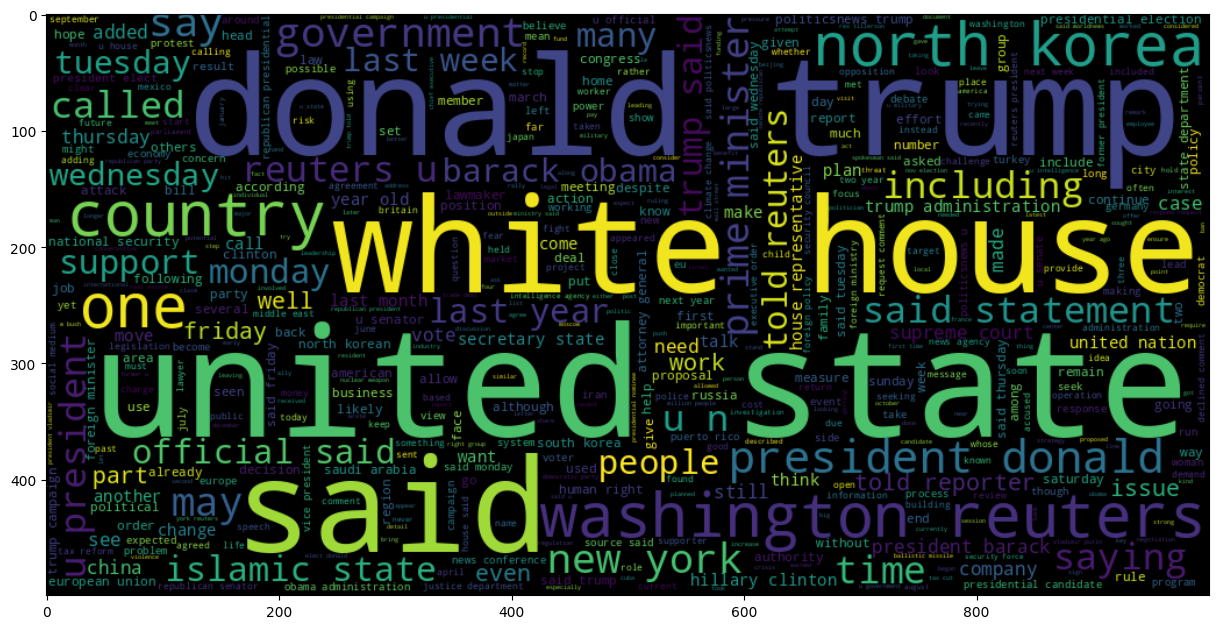

In [ ]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(data[data.target == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

2.WordCloud for Fake News

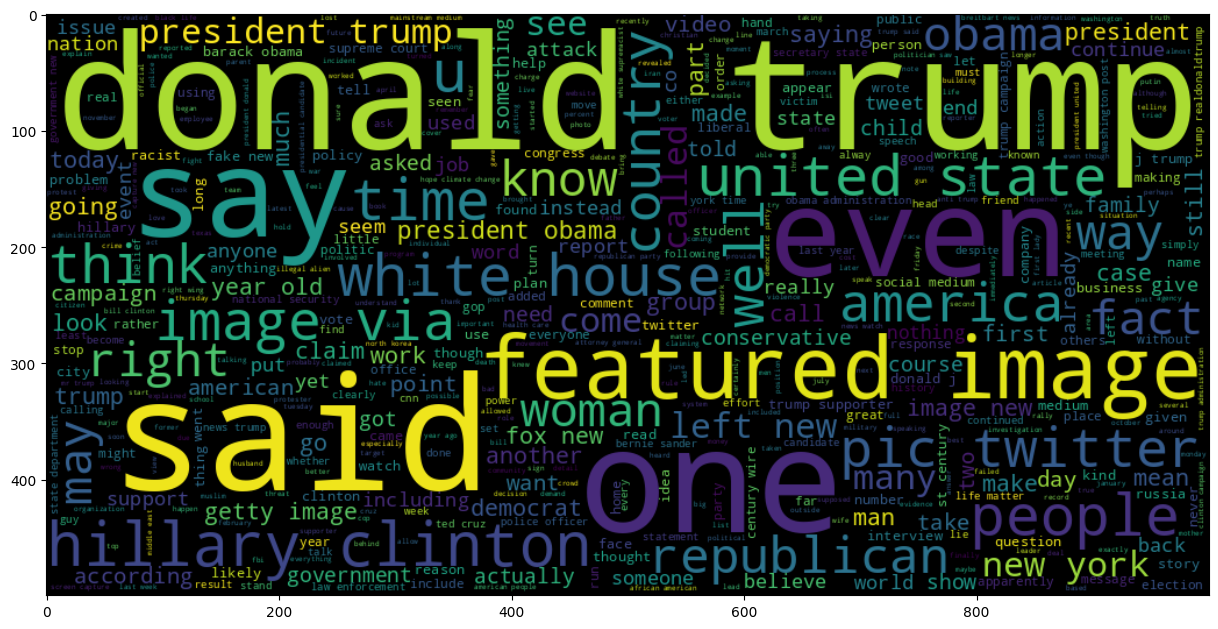

In [ ]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(data[data.target == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

Number of words in each text

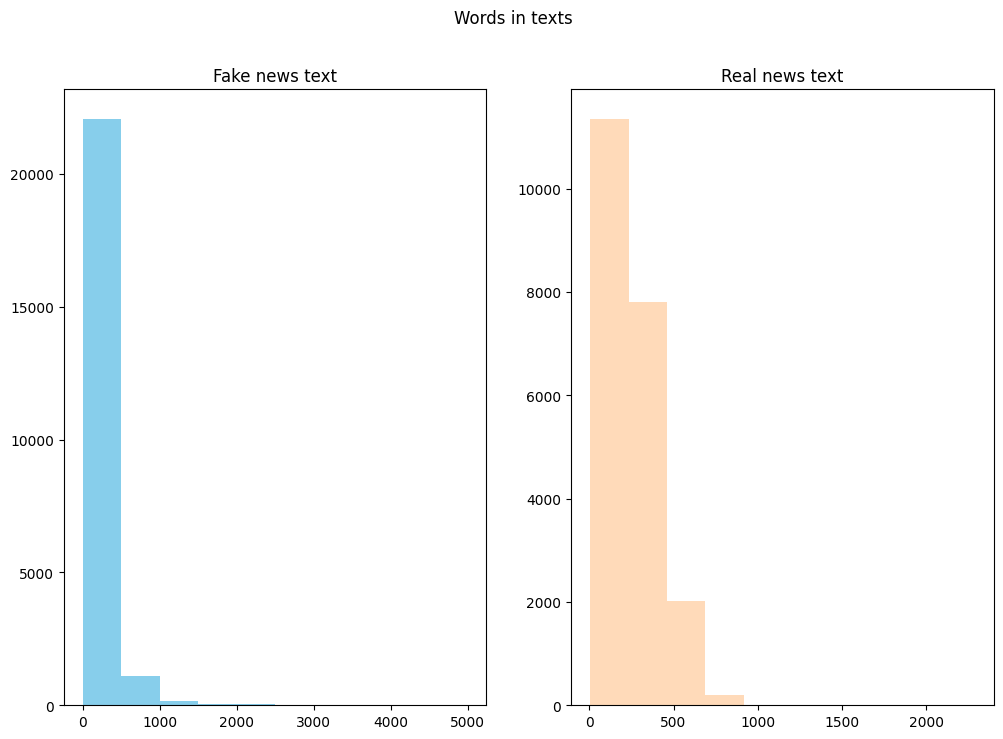

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=data[data['target']==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='SkyBlue')
ax1.set_title('Fake news text')
text_len=data[data['target']==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='PeachPuff')
ax2.set_title('Real news text')
fig.suptitle('Words in texts')
plt.show()

N-Gram Analysis

In [ ]:
texts = ' '.join(data['text'])

In [ ]:
string = texts.split(" ")

In [ ]:
def draw_n_gram(string,i):
    n_gram = (pd.Series(nltk.ngrams(string, i)).value_counts())[:15]
    n_gram_df=pd.DataFrame(n_gram)
    n_gram_df = n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    print(n_gram_df.head())
    plt.figure(figsize = (16,9))
    return sns.barplot(x='count',y='word', data=n_gram_df)

           word   count
0      (trump,)  149603
1       (said,)  133030
2          (u,)   78516
3      (state,)   62726
4  (president,)   58790


<Axes: xlabel='count', ylabel='word'>

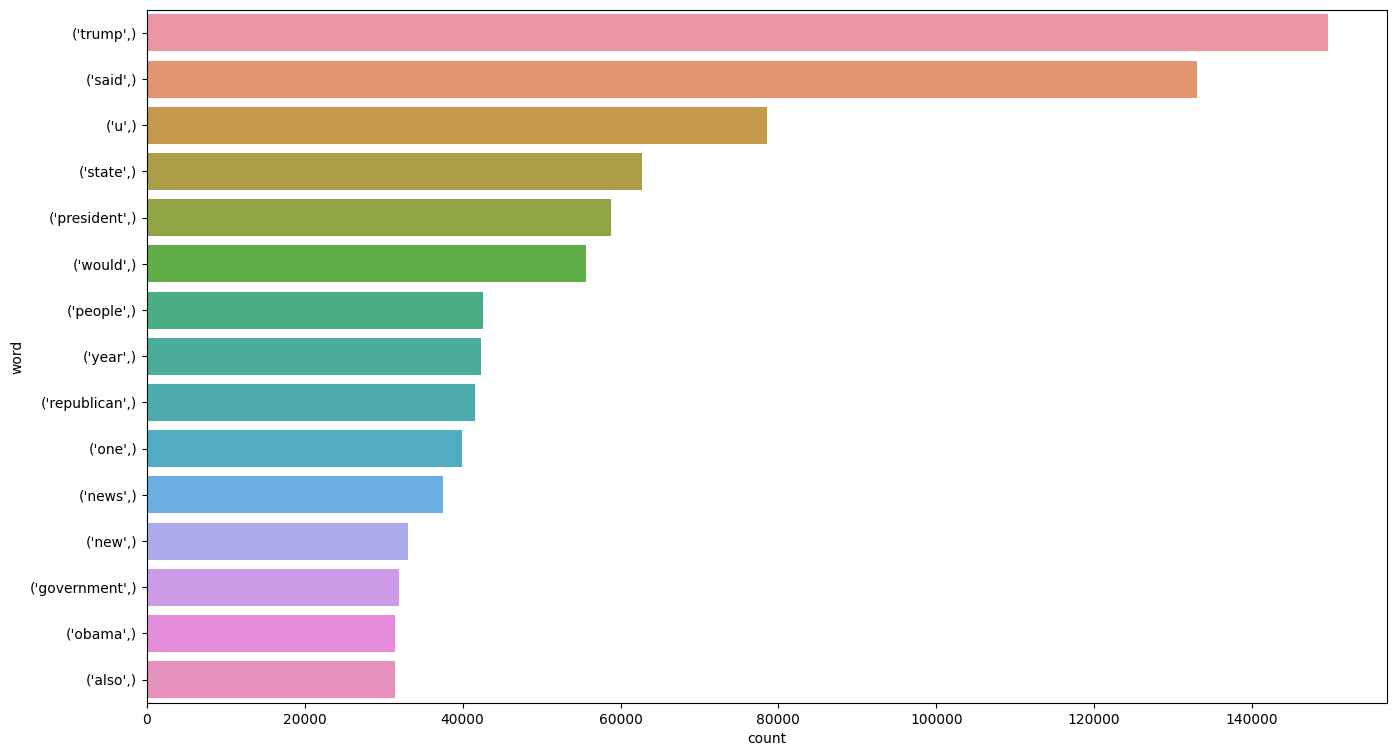

In [ ]:
#Unigram Analysis
draw_n_gram(string,1)

                 word  count
0     (donald, trump)  25203
1     (united, state)  18943
2      (white, house)  16296
3  (hillary, clinton)  10217
4         (new, york)   9305


<Axes: xlabel='count', ylabel='word'>

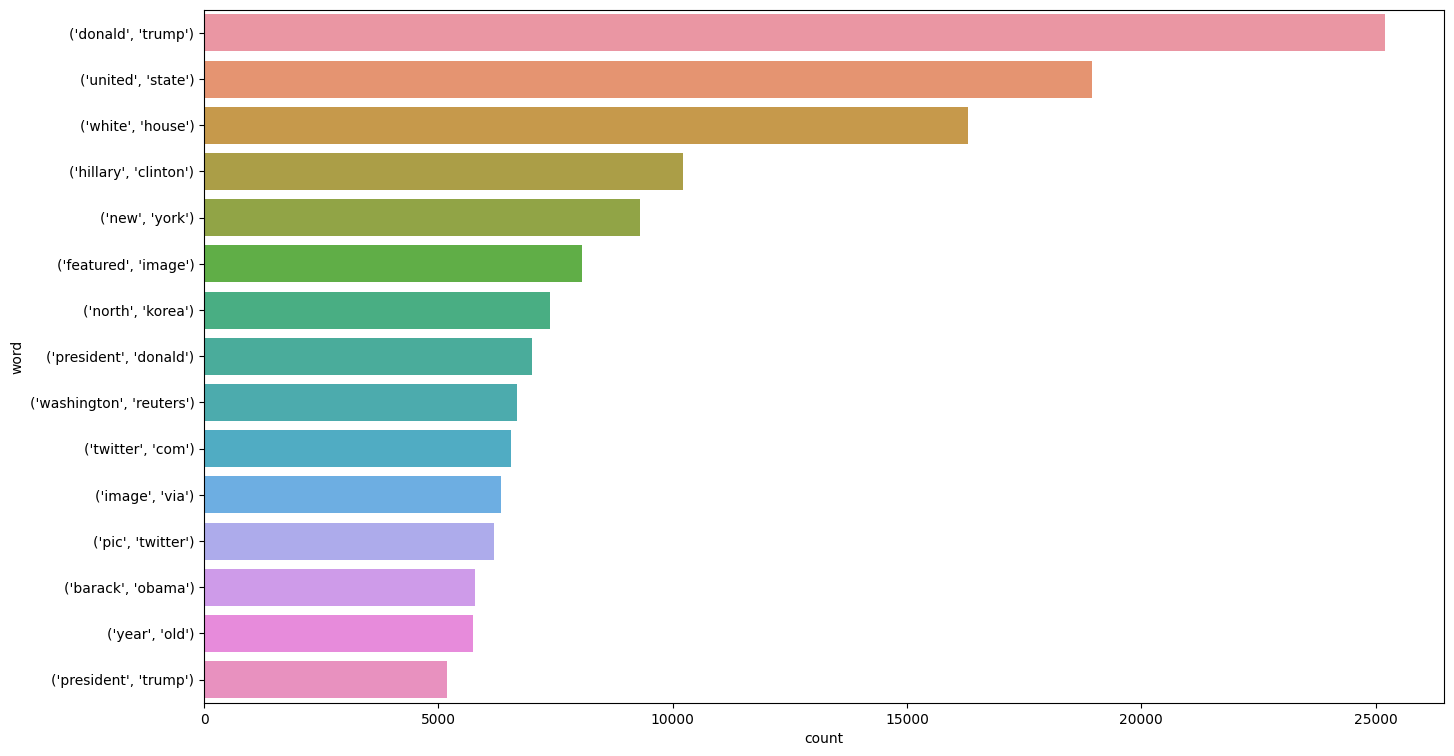

In [ ]:
#Bigram Analysis
draw_n_gram(string,2)

                         word  count
0  (president, donald, trump)   6830
1         (pic, twitter, com)   6185
2      (featured, image, via)   6029
3  (president, barack, obama)   3911
4        (getty, image, news)   3575


<Axes: xlabel='count', ylabel='word'>

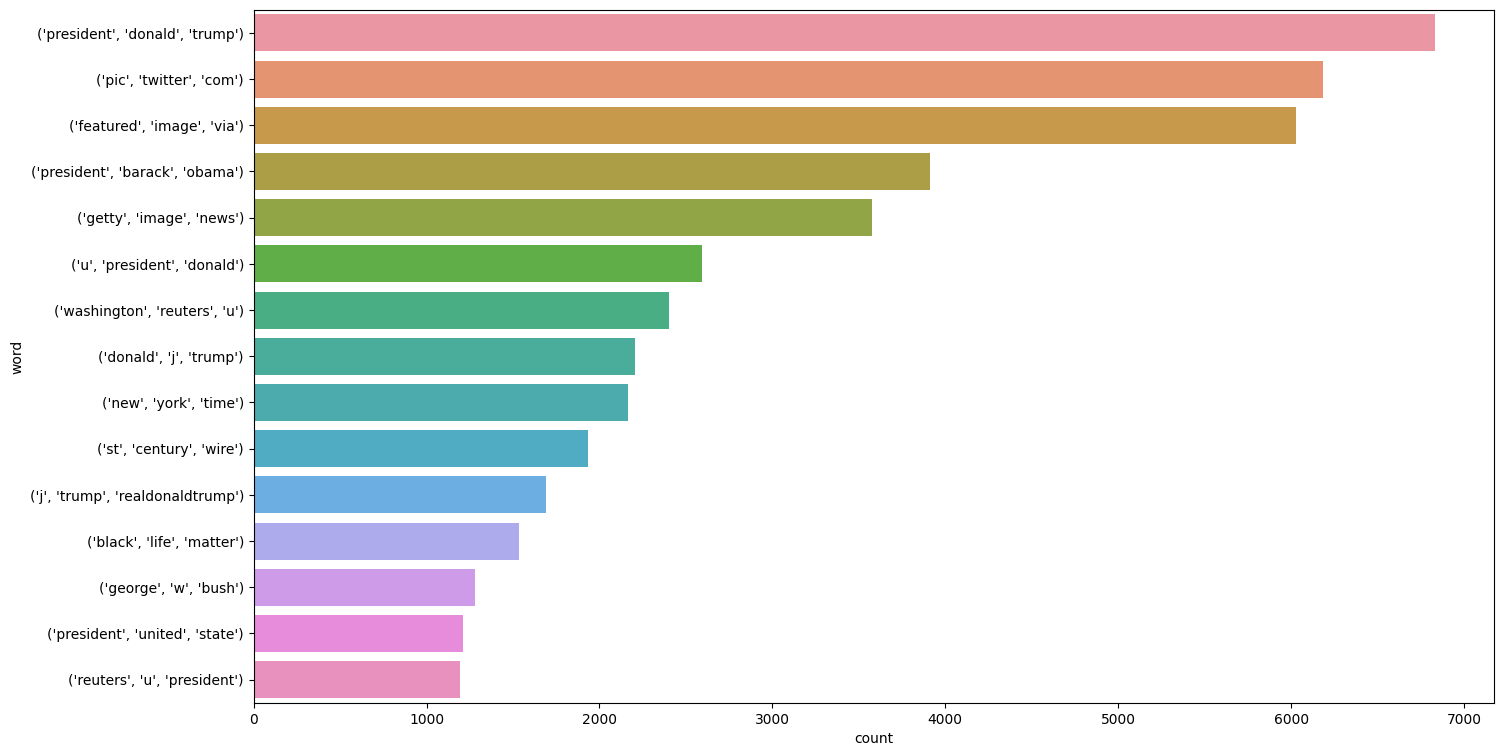

In [ ]:
#trigram Analysis
draw_n_gram(string,3)

#Modeling

Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], random_state=0)

#Tokenizing
Tokenizing Text -> Repsesenting each word by a number

Mapping of orginal word to number is preserved in word_index property of tokenizer

Lets keep all news to 300, add padding to news with less than 300 words and truncating long ones

In [ ]:
max_features = 10000
maxlen = 300

In [ ]:
import tensorflow as tf
from keras.layers import Dense


In [ ]:
import re

# Define a regular expression to match non-alphabetic characters
non_alpha = re.compile('[^a-zA-Z ]')

# Remove non-alphabetic characters from each string in X_train
X_train_clean = []
for string in X_train:
    string_clean = non_alpha.sub('', str(string))
    X_train_clean.append(string_clean)

# Use the cleaned dataset for tokenization
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train_clean)
tokenized_train = tokenizer.texts_to_sequences(X_train_clean)
X_train = tf.keras.preprocessing.sequence.pad_sequences(tokenized_train, maxlen=maxlen)





In [ ]:
tokenized_test = tokenizer.texts_to_sequences(X_test.astype(str).tolist())
X_test = tf.keras.preprocessing.sequence.pad_sequences(tokenized_test, maxlen=maxlen)




Training LSTM Model

In [ ]:
batch_size = 256
epochs = 10
embed_size = 100

In [ ]:
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, input_length=maxlen, trainable=False))
#LSTM
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=128 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          1000000   
                                                                 
 lstm_2 (LSTM)               (None, 300, 128)          117248    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,252,993
Trainable params: 252,993
Non-trainable params: 1,000,000
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=batch_size, shuffle=True, verbose = 1)

Epoch 1/10
93/93 [==============================] - 263s 3s/step - loss: 0.4959 - accuracy: 0.7636 - val_loss: 0.3173 - val_accuracy: 0.8669
Epoch 2/10
93/93 [==============================] - 256s 3s/step - loss: 0.3286 - accuracy: 0.8619 - val_loss: 0.2577 - val_accuracy: 0.8950
Epoch 3/10
93/93 [==============================] - 259s 3s/step - loss: 0.3256 - accuracy: 0.8580 - val_loss: 0.3638 - val_accuracy: 0.8257
Epoch 4/10
93/93 [==============================] - 256s 3s/step - loss: 0.2567 - accuracy: 0.8955 - val_loss: 0.1266 - val_accuracy: 0.9584
Epoch 5/10
93/93 [==============================] - 258s 3s/step - loss: 0.1205 - accuracy: 0.9560 - val_loss: 0.0745 - val_accuracy: 0.9761
Epoch 6/10
93/93 [==============================] - 260s 3s/step - loss: 0.0679 - accuracy: 0.9721 - val_loss: 0.0547 - val_accuracy: 0.9789
Epoch 7/10
93/93 [==============================] - 258s 3s/step - loss: 0.0538 - accuracy: 0.9787 - val_loss: 0.0608 - val_accuracy: 0.9767
Epoch 8/10
93

Analysis After Training

In [ ]:
model.save("LSTM")

NameError: ignored

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 204s 193ms/step - loss: 0.0405 - accuracy: 0.9859
Accuracy of the model on Training Data is -  98.59234690666199 %
351/351 [==============================] - 69s 197ms/step - loss: 0.0408 - accuracy: 0.9869
Accuracy of the model on Testing Data is -  98.69042038917542 %


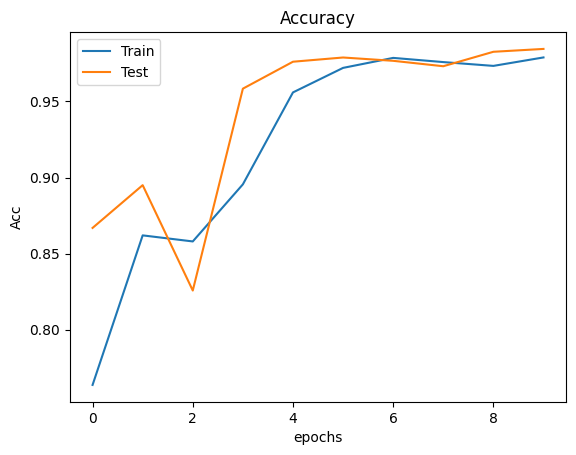

In [ ]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

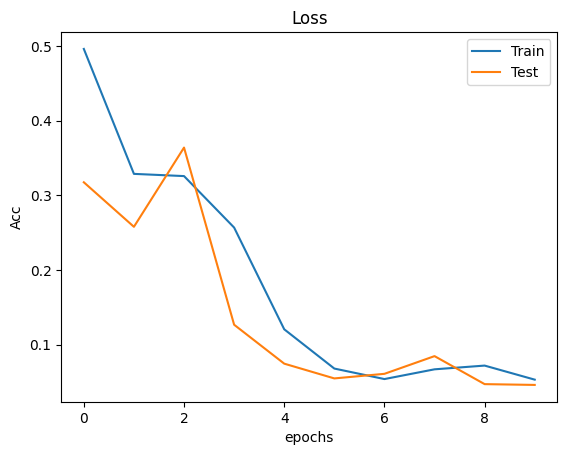

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int")
print(classification_report(y_test, y_pred))

351/351 [==============================] - 67s 190ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5858
           1       0.98      0.99      0.99      5367

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225

